In [4]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout, Layer
from keras.optimizers import Adam, Adadelta

In [5]:
!pip install stow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 741.2 kB/s eta 0:00:00


In [6]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

In [7]:
import requests
import zipfile
import tarfile
from io import BytesIO

def download_and_extract(url, dest_dir):
    # Download zip file
    response = requests.get(url)

    if response.status_code == 200:
        os.makedirs(dest_dir, exist_ok=True)

        with zipfile.ZipFile(BytesIO(response.content), 'r') as zip_ref:
            zip_ref.extractall(dest_dir)

        iam_words_dir = os.path.join(dest_dir, 'IAM_Words')

        # Unzip the file words.tgz
        words_tgz_path = os.path.join(iam_words_dir, 'words.tgz')
        with tarfile.open(words_tgz_path, 'r:gz') as tar_ref:
            tar_ref.extractall(os.path.join(iam_words_dir, 'words'))

# Especificar la URL del archivo zip y el directorio de destino
url = "https://git.io/J0fjL"
dest_dir = "Datasets"
# Llamar a la función para descargar y extraer
download_and_extract(url, dest_dir)

print("Download and extraction completed")

Download and extraction completed


In [8]:
import stow
from tqdm import tqdm
dataset_path = "Datasets/IAM_Words"

train_imgs_paths, temp_train_labels = [], []
val_imgs_paths, val_labels = [], []

# Preprocess the dataset by the specific IAM_Words dataset file structure
words = open(stow.join(dataset_path, "words.txt"), "r").readlines()
counter = 0

for line in tqdm(words):
    counter = counter +1

    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[1] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = line_split[0][:8]
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip('\n')

    rel_path = stow.join(dataset_path, "words", folder1, folder2, file_name)
    if not os.path.exists(rel_path):
        continue
    if counter%10 == 0:
      train_imgs_paths.append(rel_path)
      temp_train_labels.append(label)
    # This is done when we want to get some images from trainig dataset for validation
    #elif counter%122 == 0:
    #  val_imgs_paths.append(rel_path)
    #  val_labels.append(label)


100%|██████████| 115338/115338 [00:06<00:00, 19207.90it/s]


In [36]:
# For data augmentation
def erode_image(img):
  kernel = np.ones((5, 5), np.uint8)
  return cv2.erode(img, kernel, iterations=1)

def dilate_image(img):
  kernel = np.ones((5, 5), np.uint8)
  return cv2.dilate(img, kernel, iterations=1)

def darken_image(image, contrast=1.5, brightness=1.7):
  return cv2.addWeighted(image, contrast, np.zeros(image.shape, image.dtype), 0, brightness)

In [10]:
def preprocess(img):
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255 # blank white image

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [37]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

train_x = []
train_labels = []
train_size = len(train_imgs_paths)
print("Images paths:",train_size)
counter = 0


for i in range(train_size):
    counter = counter + 1
    img_dir = train_imgs_paths[i]
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    label = temp_train_labels[i]
    image1 = preprocess(image)
    image1 = image1/255.
    train_x.append(image1)
    train_labels.append(label)

    # This part is done when we want to augment data
    if counter%2 == 0:
      image2 = darken_image(image)
      image2 = preprocess(image2)
      image2 = image2/255.
      train_x.append(image2)
      train_labels.append(label)
    if counter%3 == 0:
      image3 = erode_image(image)
      image3 = preprocess(image3)
      image3 = image3/255.
      train_x.append(image3)
      train_labels.append(label)
    if counter%4 == 0:
      image4 = dilate_image(image)
      image4 = preprocess(image4)
      image4 = image4/255.
      train_x.append(image4)
      train_labels.append(label)


train_size = len(train_x)
print("Total training images:",train_size)

Images paths: 2171
Total training images: 4521


Tony


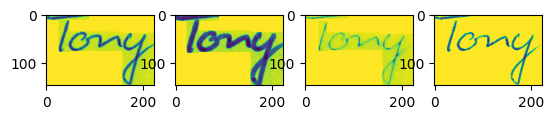

In [38]:
# check train_imgs_paths and temp_train_labels and augmentation functions
img_dir = train_imgs_paths[300]
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
print(temp_train_labels[300])
ax = plt.subplot(1,4,1)
plt.imshow(image)

ax = plt.subplot(1,4,2)
plt.imshow(erode_image(image))

ax = plt.subplot(1,4,3)
plt.imshow(dilate_image(image))

ax = plt.subplot(1,4,4)
plt.imshow(darken_image(image))

In [39]:
dataset_path = "Datasets/test_data"

val_imgs_paths, val_labels = [], []

words = open(stow.join(dataset_path, "words.txt"), "r").readlines()
for line in tqdm(words):
    line_split = line.split(" ")
    file_name = line_split[0]
    label = line_split[-1].rstrip('\n')

    rel_path = stow.join(dataset_path, "images", file_name)
    if not os.path.exists(rel_path):
        continue

    val_imgs_paths.append(rel_path)
    val_labels.append(label)

100%|██████████| 76/76 [00:00<00:00, 15666.54it/s]


In [40]:
valid_x = []
valid_size = len(val_imgs_paths)

print("Total validation images:",valid_size)

for i in range(valid_size):
    img_dir = val_imgs_paths[i]
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

Total validation images: 76


bed


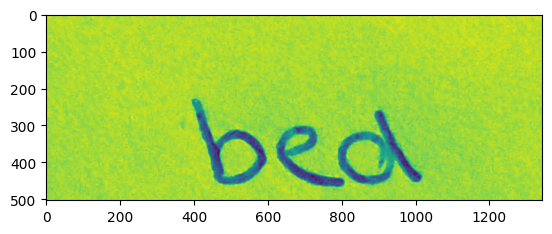

In [41]:
# check val_imgs_paths and val_labels
img_dir = val_imgs_paths[66]
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
print(val_labels[66])
plt.imshow(image)


In [42]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [43]:
alphabets = "\"!#&'(),-.0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWYZabcdefghijklmnopqrstuvwxyz"
max_str_len = max([len(label) for label in train_labels])
num_of_characters = len(alphabets) +1
num_of_timestamps = 64

def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [44]:
print(label_to_num('once-and-for-all'))

[62 61 50 52  8 48 61 51  8 53 62 65  8 48 59 59]


In [45]:
array = [62, 61, 50, 52,  8, 48, 61, 51,  8, 53, 62, 65,  8 ,48, 59, 59]
print(num_to_label(array))

once-and-for-all


In [46]:
# Storing info about labels
# The length of each label is padded to the maximum string length (max_str_len).
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train_labels[i])
    train_y[i, 0:len(train_labels[i])]= label_to_num(train_labels[i])

In [47]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(val_labels[i])
    valid_y[i, 0:len(val_labels[i])]= label_to_num(val_labels[i])

In [48]:
# Defining the model
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN, extracting features from the data.
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT, produces the final output with a number of neurons equal to num_of_characters.
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)

# Converts the raw output into probability scores for each class (character).
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 256, 64, 32)       128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [49]:
# It handles the necessary adjustments to the predicted output before computing
# the CTC loss using the Keras backend function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the early predictions may not be reliable, so we remove the first two time steps in the sequence
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [50]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [51]:
# Logging setup
logs_dir = "logs/"
os.makedirs(logs_dir, exist_ok=True)

# Save checkpoints during training
checkpoint_filepath = '/content/logs/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

#keras.models.load_model(checkpoint_filepath)

LEARNING_RATE = 0.001
EPOCHS = 10
BATCH_SIZE = 24

# Log hyperparameters
hyperparam_file = open('/content/logs/hyperparameters.txt', "w")
hyperparam_file.write("Learning Rate: " + str(LEARNING_RATE) + "\n")
hyperparam_file.write("Epochs: " + str(EPOCHS) + "\n")
hyperparam_file.write("Batch Size: " + str(BATCH_SIZE) + "\n")

15

In [52]:
def cer(real, pred):
	real_chars = real.split()
	pred_chars = pred.split()
	# Counting the number of substitutions, deletions, and insertions
	substitutions = sum(1 for ref, hyp in zip(real_chars, pred_chars) if ref != hyp)
	deletions = len(real_chars) - len(pred_chars)
	insertions = len(pred_chars) - len(real_chars)
	# Total number of words in the reference text
	total_chars = len(real_chars)
	# Calculating the Character Error Rate (CER)
	cer = (substitutions + deletions + insertions) / total_chars
	return cer

In [53]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = LEARNING_RATE))

# Training callbacks
csv_logger = CSVLogger('/content/logs/csv_logger.csv', append=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=EPOCHS, batch_size=BATCH_SIZE,
                callbacks=[model_checkpoint_callback, csv_logger, early_stopping])

Epoch 1/10
 33/189 [====>.........................] - ETA: 5:37 - loss: 27.1718

KeyboardInterrupt: ignored

In [54]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

3/3 [==============================] - 3s 360ms/step


In [55]:
y_true = val_labels[0:valid_size]
correct_char = 0
total_char = 0
correct = 0
sum_cer = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    sum_cer += cer(tr, pr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))
print('Mean Character Error Rate    : %.2f%%' %(sum_cer*100/valid_size))

Correct characters predicted : 0.00%
Correct words predicted      : 0.00%
Mean Character Error Rate    : 0.00%


1/1 [==============================] - 0s 118ms/step


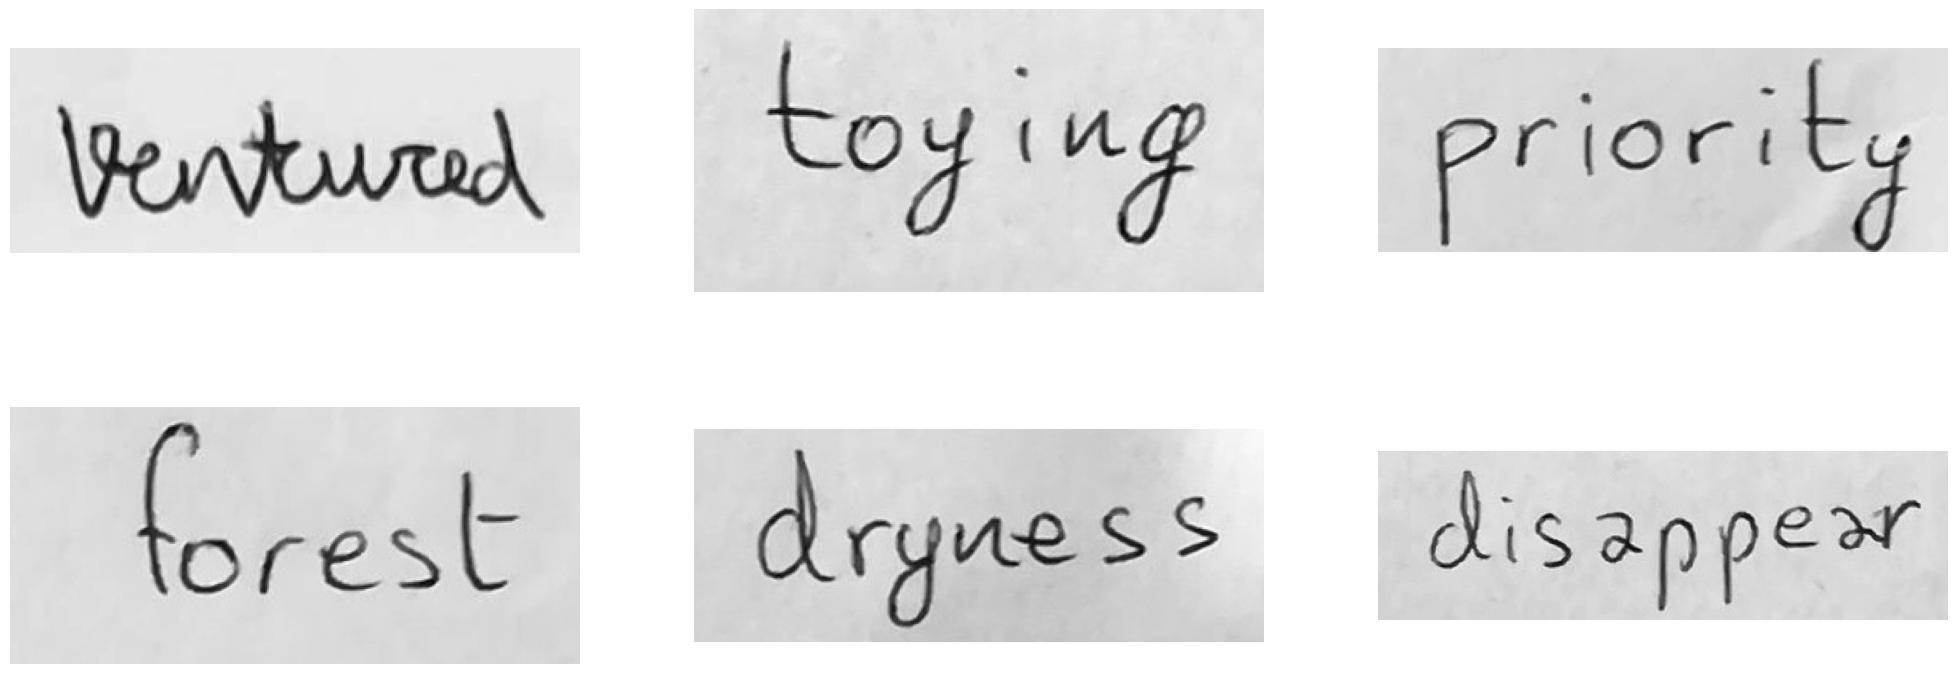

In [56]:
# Sanity check
plt.figure(figsize=(25, 30))
for i in range(6):
    ax = plt.subplot(2,3, i+1)
    img_dir = val_imgs_paths[i+9]
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)